In [260]:
import jieba
import jieba.posseg as pseg
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from gensim.models.fasttext import FastText
from collections import Counter
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

train_path = "../datasets/AutoMaster_TrainSet.csv"
test_path = "../datasets/AutoMaster_TestSet.csv"

#切分词之后保存文件
train_seg_path = '../datasets/train_seg.csv'
test_seg_path = '../datasets/test_seg.csv'

#合并列之后保存文件
train_seg_merge_path = '../datasets/train_seg_merge.csv'
test_seg_merge_path = '../datasets/test_seg_merge.csv'

In [162]:
df_train = pd.read_csv(train_path, encoding='utf-8')
df_test = pd.read_csv(test_path, encoding='utf-8')

In [164]:
df_train.head()

,QID,Brand,Model,Question,Dialogue,Report
0,Q1,奔驰,奔驰GL级,方向机重，助力泵，方向机都换了还是一样,技师说：[语音]|车主说：新的都换了|车主说：助力泵，方向机|技师说：[语音]|车主说：换了...,随时联系
1,Q2,奔驰,奔驰M级,奔驰ML500排气凸轮轴调节错误,技师说：你这个有没有电脑检测故障代码。|车主说：有|技师说：发一下|车主说：发动机之前亮故障...,随时联系
2,Q3,宝马,宝马X1(进口),2010款宝马X1，2011年出厂，2.0排量，通用6L45变速箱，原地换挡位PRND车辆闯...,技师说：你好，4缸自然吸气发动机N46是吧，先挂空档再挂其他档有没有闯动呢，变速箱油液位是否...,行驶没有顿挫的感觉，原地换挡有闯动，刹车踩重没有，这是力的限制的作用，应该没有问题
3,Q4,Jeep,牧马人,3.0V6发动机号在什么位置，有照片最好！,技师说：右侧排气管上方，缸体上靠近变速箱|车主说：[图片]|车主说：是不是这个？|车主说：这...,举起车辆，在左前轮这边的缸体上
4,Q5,奔驰,奔驰C级,2012款奔驰c180怎么样，维修保养，动力，值得拥有吗,技师说：家庭用车的话，还是可以入手的|技师说：维修保养费用不高|车主说：12年的180市场价...,家庭用车可以入手的，维修保养价格还可以。车况好，价格合理可以入手


In [165]:
df_test.head()

,QID,Brand,Model,Question,Dialogue
0,Q1,大众(进口),高尔夫(进口),我的帕萨特烧机油怎么办怎么办？,技师说：你好，请问你的车跑了多少公里了，如果在保修期内，可以到当地的4店里面进行检查维修。如...
1,Q2,一汽-大众奥迪,奥迪A6,修一下多少钱是换还是修,技师说：你好师傅！抛光处理一下就好了！50元左右就好了，希望能够帮到你！祝你生活愉快！
2,Q3,上汽大众,帕萨特,帕萨特领域 喇叭坏了 店里说方向盘里线坏了 换一根两三百不等 感觉太贵,技师说：你好，气囊油丝坏了吗，这个价格不贵。可以更换。
3,Q4,南京菲亚特,派力奥,发动机漏气会有什么征兆？,技师说：你好！一：发动机没力，并伴有“啪啪”的漏气声音。二：发动机没力，并伴有排气管冒黑烟。...
4,Q5,东风本田,思铂睿,请问 那天右后胎扎了订，补了胎后跑高速80多开始有点抖，110时速以上抖动明显，以为是未做动...,技师说：你好师傅！可能前轮平衡快脱落或者不平衡造成的！建议前轮做一下动平衡就好了！希望能够帮...


### 分词并保存至csv文件

In [166]:
stop_words = '，：？。? ！! @ # $ % ^ & * ( ) [ ] { } > < = - + ~ ` --- (i (or / ; ;\' $1 |> \
                    --------- -------------------------------------------------------------------------- \
                    ========================= \
                    0 1 2 3 4 5 6 7 8 9 13 15 30 24 20 "a" tk> 95 45'

In [167]:
def process(s):
    seg = [i for i in jieba.cut(s) if i not in stop_words ]
    return " ".join(seg)

In [168]:
def build_vocab(df, sort=True, min_count=0, lower=False):
    data_columns = df.columns.tolist()
    data_seg = []
    df_new = pd.DataFrame()
    for col in data_columns:
        data_col = df[col]
        df[col] = df[col].apply(str)
        df_new[col] = df[col].apply(process)
    return df_new

In [224]:
df_train_split = build_vocab(df_train)
df_test_split = build_vocab(df_test)
df_train_split.to_csv(train_seg_path, index=False)
df_test_split.to_csv(test_seg_path, index=False)

print(df_train_split.head())
print(df_test_split.head())

  QID Brand     Model                                           Question  \
0  Q1    奔驰   奔驰 GL 级                         方向机 重 助力 泵 方向机 都 换 了 还是 一样   
1  Q2    奔驰    奔驰 M 级                              奔驰 ML500 排气 凸轮轴 调节 错误   
2  Q3    宝马  宝马 X1 进口  2010 款 宝马 X1 2011 年 出厂 2.0 排量 通用 6L45 变速箱 原地 换...   
3  Q4  Jeep       牧马人                       3.0 V6 发动机 号 在 什么 位置 有 照片 最好   
4  Q5    奔驰    奔驰 C 级                 2012 款 奔驰 c180 怎么样 维修保养 动力 值得 拥有 吗   

                                            Dialogue  \
0  技师 说 语音 车主 说 新 的 都 换 了 车主 说 助力 泵 方向机 技师 说 语音 车...   
1  技师 说 你 这个 有没有 电脑 检测 故障 代码 车主 说 有 技师 说 发 一下 车主 ...   
2  技师 说 你好 缸 自然 吸气 发动机 N46 是 吧 先挂 空档 再 挂 其他 档 有没有...   
3  技师 说 右侧 排气管 上方 缸体 上 靠近 变速箱 车主 说 图片 车主 说 是不是 这个...   
4  技师 说 家庭 用车 的话 还是 可以 入手 的 技师 说 维修保养 费用 不高 车主 说 ...   

                                              Report  
0                                              随时 联系  
1                                              随时 联系  
2  行驶 没有 顿挫 的 感觉 原地 换挡 有 闯动 刹车 踩 重 没有 这 是

### 使用Word2Vec训练词向量

In [220]:
def build_dataset(data_train, data_test):
   
    lines = []
    for k in ['Brand', 'Model', 'Question', 'Dialogue', 'Report']:
        train_str = list(data_train[k].apply(str).values)
        if k != 'Report':
            test_str = list(data_test[k].apply(str).values)

        train_split = [i.split(' ') for i in train_str]
        test_split = [i.split(' ') for i in test_str]

        lines.extend(train_split)
        lines.extend(test_split)

    return lines

In [240]:
data_train = pd.read_csv(train_seg_path)
data_test = pd.read_csv(test_seg_path)

In [241]:
train_texts = build_dataset(data_train, data_test)

In [242]:
len(train_texts)

514715

In [183]:
w2v_bin_path = "../model.bin"

In [184]:
embedding_size = 100

In [205]:
def build(train_vocab, out_path=None, embedding_size=100, sentence_path='',
          w2v_bin_path="w2v.bin", min_count=5, col_sep='\t'):
#     sentences = extract_sentence(train_seg_path, test_seg_path, col_sep=col_sep)
#     save_sentence(sentences, sentence_path)
    print('train w2v model...')
    # train model
    w2v = Word2Vec(sg=1, sentences=train_vocab,
                   size=embedding_size, window=5, min_count=min_count, iter=40)
    w2v.wv.save_word2vec_format(w2v_bin_path, binary=True)
    print("save %s ok." % w2v_bin_path)
    # test
    sim = w2v.wv.similarity('奔驰', '宝马')
    print('奔驰 vs 宝马 similarity score:', sim)


In [206]:
build(train_texts[:300], w2v_bin_path=w2v_bin_path, min_count=3)

train w2v model...
save ../model.bin ok.
奔驰 vs 宝马 similarity score: 0.039468948


In [207]:
model = KeyedVectors.load_word2vec_format(w2v_bin_path, binary=True)

In [209]:
model.most_similar("奔驰")

[('东风', 0.2315138876438141),
 ('宝骏', 0.21097329258918762),
 ('起亚', 0.18721024692058563),
 ('日产', 0.1842527687549591),
 ('标致', 0.15134087204933167),
 ('欧尚', 0.09587984532117844),
 ('保时捷', 0.06615843623876572),
 ('本田', 0.06301847100257874),
 ('长城', 0.06004756689071655),
 ('宝马', 0.039468955248594284)]

In [216]:
model.index2word[3]

'别克'

In [217]:
model.word_vec('别克')

array([ 1.4396359e-03, -2.5544900e-03, -4.8779976e-03,  7.4765721e-04,
        3.2337739e-03,  4.3000001e-03, -2.8546485e-03,  1.3069223e-03,
       -2.9945802e-03,  3.1224728e-04, -3.7782001e-03,  3.4384958e-03,
       -9.1257464e-04,  1.3322992e-03,  4.6670614e-03,  3.9602937e-03,
       -4.2571691e-03,  4.6949331e-03, -3.9815432e-03,  1.4310654e-03,
       -1.6319774e-03,  3.2838997e-03,  2.6491319e-03,  2.4557707e-03,
        3.1291265e-03,  3.9677913e-03, -1.7343042e-03,  2.0405217e-03,
        2.6539755e-03, -1.8856693e-03,  4.9369305e-04, -2.4054674e-03,
        1.5585993e-03,  3.1631601e-03, -1.1317373e-03, -7.5364346e-04,
       -4.1949819e-03,  3.9945319e-03,  3.5451277e-04,  1.8557057e-03,
        1.1592286e-04, -9.2709163e-04,  2.2009669e-03,  1.5961557e-03,
        1.1866624e-03, -1.5302334e-03, -1.3013224e-05, -3.8788784e-03,
        4.5924755e-03, -3.3557278e-03,  1.5895633e-03, -1.6391095e-04,
        1.8553362e-03, -3.8218403e-03, -2.9533327e-04, -2.9124385e-03,
      

In [218]:
model.vectors[3]

array([ 1.4396359e-03, -2.5544900e-03, -4.8779976e-03,  7.4765721e-04,
        3.2337739e-03,  4.3000001e-03, -2.8546485e-03,  1.3069223e-03,
       -2.9945802e-03,  3.1224728e-04, -3.7782001e-03,  3.4384958e-03,
       -9.1257464e-04,  1.3322992e-03,  4.6670614e-03,  3.9602937e-03,
       -4.2571691e-03,  4.6949331e-03, -3.9815432e-03,  1.4310654e-03,
       -1.6319774e-03,  3.2838997e-03,  2.6491319e-03,  2.4557707e-03,
        3.1291265e-03,  3.9677913e-03, -1.7343042e-03,  2.0405217e-03,
        2.6539755e-03, -1.8856693e-03,  4.9369305e-04, -2.4054674e-03,
        1.5585993e-03,  3.1631601e-03, -1.1317373e-03, -7.5364346e-04,
       -4.1949819e-03,  3.9945319e-03,  3.5451277e-04,  1.8557057e-03,
        1.1592286e-04, -9.2709163e-04,  2.2009669e-03,  1.5961557e-03,
        1.1866624e-03, -1.5302334e-03, -1.3013224e-05, -3.8788784e-03,
        4.5924755e-03, -3.3557278e-03,  1.5895633e-03, -1.6391095e-04,
        1.8553362e-03, -3.8218403e-03, -2.9533327e-04, -2.9124385e-03,
      

### Convert Sentences to Ids

In [158]:
def word2index(model):
    """
    建立词-->索引字典
    """
    word2index = {}
    for i in range(len(model.vocab)):
        word = model.index2word[i]
        word2index[word] = i
    return word2index

word2index_dic = word2index(model)
word2index_dic['<start>'] = len(word2index_dic)
word2index_dic['<end>'] = len(word2index_dic) + 1

def process_split(sen):
    """将句子转为ids
    """
    sen_list = []
    if sen is not None:
        sen_list = [str(word2index_dic[i]) for i in str(sen).split(' ')]
    return ' '.join(sen_list)

def convertSentences2Ids(df):
    df_process = df.copy()
    for col in ['Brand', 'Model', 'Question', 'Dialogue', 'Report']:
        df_col = df_process[col].apply(process_split)
        df_process[col + '_' + 'index'] = df_col
    return df_process

df_index = convertSentences2Ids(df_read)

### 实现Seq2Seq

In [243]:
data_train.head()

,QID,Brand,Model,Question,Dialogue,Report
0,Q1,奔驰,奔驰 GL 级,方向机 重 助力 泵 方向机 都 换 了 还是 一样,技师 说 语音 车主 说 新 的 都 换 了 车主 说 助力 泵 方向机 技师 说 语音 车...,随时 联系
1,Q2,奔驰,奔驰 M 级,奔驰 ML500 排气 凸轮轴 调节 错误,技师 说 你 这个 有没有 电脑 检测 故障 代码 车主 说 有 技师 说 发 一下 车主 ...,随时 联系
2,Q3,宝马,宝马 X1 进口,2010 款 宝马 X1 2011 年 出厂 2.0 排量 通用 6L45 变速箱 原地 换...,技师 说 你好 缸 自然 吸气 发动机 N46 是 吧 先挂 空档 再 挂 其他 档 有没有...,行驶 没有 顿挫 的 感觉 原地 换挡 有 闯动 刹车 踩 重 没有 这 是 力 的 限制 ...
3,Q4,Jeep,牧马人,3.0 V6 发动机 号 在 什么 位置 有 照片 最好,技师 说 右侧 排气管 上方 缸体 上 靠近 变速箱 车主 说 图片 车主 说 是不是 这个...,举起 车辆 在 左 前轮 这边 的 缸体 上
4,Q5,奔驰,奔驰 C 级,2012 款 奔驰 c180 怎么样 维修保养 动力 值得 拥有 吗,技师 说 家庭 用车 的话 还是 可以 入手 的 技师 说 维修保养 费用 不高 车主 说 ...,家庭 用车 可以 入手 的 维修保养 价格 还 可以 车况 好 价格合理 可以 入手


In [244]:
data_test.head()

,QID,Brand,Model,Question,Dialogue
0,Q1,大众 进口,高尔夫 进口,我 的 帕萨特 烧 机油 怎么办 怎么办,技师 说 你好 请问 你 的 车 跑 了 多少 公里 了 如果 在 保修期 内 可以 到 当...
1,Q2,一汽 大众 奥迪,奥迪 A6,修 一下 多少 钱 是 换 还是 修,技师 说 你好 师傅 抛光 处理 一下 就 好 了 50 元 左右 就 好 了 希望 能够 ...
2,Q3,上汽 大众,帕萨特,帕萨特 领域 喇叭 坏 了 店里 说 方向盘 里线 坏 了 换 一根 两三百 不 等 感觉 太贵,技师 说 你好 气囊 油丝坏 了 吗 这个 价格 不 贵 可以 更换
3,Q4,南京 菲亚特,派力奥,发动机 漏气 会 有 什么 征兆,技师 说 你好 一 发动机 没力 并 伴有 “ 啪啪 ” 的 漏气 声音 二 发动机 没力 ...
4,Q5,东风 本田,思铂 睿,请问 那天 右后 胎扎 了 订 补 了 胎后 跑 高速 80 多 开始 有点 抖 110 时...,技师 说 你好 师傅 可能 前轮 平衡 快 脱落 或者 不 平衡 造成 的 建议 前轮 做 ...


In [245]:
data_train.shape, data_test.shape

((82943, 6), (20000, 5))

In [246]:
data_train.dropna(axis=0, how='any', inplace=True)
data_test.dropna(axis=0, how='any', inplace=True)

In [247]:
data_train.shape, data_test.shape

((81559, 6), (19987, 5))

In [248]:
#合并除report的字段
data_train['input'] = data_train['Brand'] + ' ' + data_train['Model'] + ' ' + data_train['Question'] + ' ' + data_train['Dialogue']
data_train.drop(['Brand', 'Model', 'Question', 'Dialogue'], axis=1, inplace=True)

data_test['input'] = data_test['Brand'] + ' ' + data_test['Model'] + ' ' + data_test['Question'] + ' ' + data_test['Dialogue']
data_test.drop(['Brand', 'Model', 'Question', 'Dialogue'], axis=1, inplace=True)

In [249]:
data_train.head()

,QID,Report,input
0,Q1,随时 联系,奔驰 奔驰 GL 级 方向机 重 助力 泵 方向机 都 换 了 还是 一样 技师 说 语音 ...
1,Q2,随时 联系,奔驰 奔驰 M 级 奔驰 ML500 排气 凸轮轴 调节 错误 技师 说 你 这个 有没有 ...
2,Q3,行驶 没有 顿挫 的 感觉 原地 换挡 有 闯动 刹车 踩 重 没有 这 是 力 的 限制 ...,宝马 宝马 X1 进口 2010 款 宝马 X1 2011 年 出厂 2.0 排量 通用 6...
3,Q4,举起 车辆 在 左 前轮 这边 的 缸体 上,Jeep 牧马人 3.0 V6 发动机 号 在 什么 位置 有 照片 最好 技师 说 右侧 ...
4,Q5,家庭 用车 可以 入手 的 维修保养 价格 还 可以 车况 好 价格合理 可以 入手,奔驰 奔驰 C 级 2012 款 奔驰 c180 怎么样 维修保养 动力 值得 拥有 吗 技...


In [250]:
data_test.head()

,QID,input
0,Q1,大众 进口 高尔夫 进口 我 的 帕萨特 烧 机油 怎么办 怎么办 技师 说 你好 请问 你...
1,Q2,一汽 大众 奥迪 奥迪 A6 修 一下 多少 钱 是 换 还是 修 技师 说 你好 师傅 抛...
2,Q3,上汽 大众 帕萨特 帕萨特 领域 喇叭 坏 了 店里 说 方向盘 里线 坏 了 换 一根 两...
3,Q4,南京 菲亚特 派力奥 发动机 漏气 会 有 什么 征兆 技师 说 你好 一 发动机 没力 并...
4,Q5,东风 本田 思铂 睿 请问 那天 右后 胎扎 了 订 补 了 胎后 跑 高速 80 多 开始...


In [251]:
data_train.to_csv(train_seg_merge_path, index=False)
data_test.to_csv(test_seg_merge_path, index=False)

In [255]:
data_train_merge = pd.read_csv(train_seg_merge_path)
data_test_merge = pd.read_csv(test_seg_merge_path)

In [256]:
data_train_merge.head()

,QID,Report,input
0,Q1,随时 联系,奔驰 奔驰 GL 级 方向机 重 助力 泵 方向机 都 换 了 还是 一样 技师 说 语音 ...
1,Q2,随时 联系,奔驰 奔驰 M 级 奔驰 ML500 排气 凸轮轴 调节 错误 技师 说 你 这个 有没有 ...
2,Q3,行驶 没有 顿挫 的 感觉 原地 换挡 有 闯动 刹车 踩 重 没有 这 是 力 的 限制 ...,宝马 宝马 X1 进口 2010 款 宝马 X1 2011 年 出厂 2.0 排量 通用 6...
3,Q4,举起 车辆 在 左 前轮 这边 的 缸体 上,Jeep 牧马人 3.0 V6 发动机 号 在 什么 位置 有 照片 最好 技师 说 右侧 ...
4,Q5,家庭 用车 可以 入手 的 维修保养 价格 还 可以 车况 好 价格合理 可以 入手,奔驰 奔驰 C 级 2012 款 奔驰 c180 怎么样 维修保养 动力 值得 拥有 吗 技...


In [257]:
data_test_merge.head()

,QID,input
0,Q1,大众 进口 高尔夫 进口 我 的 帕萨特 烧 机油 怎么办 怎么办 技师 说 你好 请问 你...
1,Q2,一汽 大众 奥迪 奥迪 A6 修 一下 多少 钱 是 换 还是 修 技师 说 你好 师傅 抛...
2,Q3,上汽 大众 帕萨特 帕萨特 领域 喇叭 坏 了 店里 说 方向盘 里线 坏 了 换 一根 两...
3,Q4,南京 菲亚特 派力奥 发动机 漏气 会 有 什么 征兆 技师 说 你好 一 发动机 没力 并...
4,Q5,东风 本田 思铂 睿 请问 那天 右后 胎扎 了 订 补 了 胎后 跑 高速 80 多 开始...


In [258]:
def preprocess_word(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def preprocess_id(w):
    w = str(len(word2index_dic)) + ' ' + w + ' ' + str(len(word2index_dic) + 1)
    return w

In [262]:
#添加<start><end>
data_train_merge['input'] = data_train_merge['input'].apply(preprocess_word).copy()
data_train_merge['Report'] = data_train_merge['Report'].apply(preprocess_word).copy()

In [264]:
data_train_merge.head()

,QID,Report,input
0,Q1,<start> 随时 联系 <end>,<start> 奔驰 奔驰 GL 级 方向机 重 助力 泵 方向机 都 换 了 还是 一样 ...
1,Q2,<start> 随时 联系 <end>,<start> 奔驰 奔驰 M 级 奔驰 ML500 排气 凸轮轴 调节 错误 技师 说 你...
2,Q3,<start> 行驶 没有 顿挫 的 感觉 原地 换挡 有 闯动 刹车 踩 重 没有 这 是...,<start> 宝马 宝马 X1 进口 2010 款 宝马 X1 2011 年 出厂 2 ....
3,Q4,<start> 举起 车辆 在 左 前轮 这边 的 缸体 上 <end>,<start> Jeep 牧马人 3 . 0 V6 发动机 号 在 什么 位置 有 照片 最...
4,Q5,<start> 家庭 用车 可以 入手 的 维修保养 价格 还 可以 车况 好 价格合理 可...,<start> 奔驰 奔驰 C 级 2012 款 奔驰 c180 怎么样 维修保养 动力 值...


In [265]:
def tokenize(texts, max_len):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=max_words_size)
    tokenizer.fit_on_texts(texts)
    
    word_index = tokenizer.word_index
    tensor = tokenizer.texts_to_sequences(texts)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, max_len, padding='post')
    return tensor, word_index, tokenizer

In [268]:
max_words_size = 30000
max_input_size = 500
max_target_size = 50

dataset_num = 129

input_data = [str(i) for i in data_train_merge['input'].values.tolist()][:data_num]
target_data = [str(i) for i in data_train_merge['Report'].values.tolist()][:data_num]
tensor_input, word_index_input, tokenizer_input = tokenize(input_data, max_input_size)
tensor_target, word_index_target, tokenizer_target = tokenize(target_data, max_target_size)


In [269]:
def max_length(tensor): return max(len(t) for t in tensor)
max_length_targ, max_length_inp = max_length(tensor_target), max_length(tensor_input)
max_length_inp, max_length_targ

(500, 50)

In [270]:
def get_embedding(word_index_input, word_index_target, path='', embed_size=100):
    
#     num_input_en = min(max_words_size, len(word_index_input))
    num_input_en = len(word_index_input) + 1
    encoder_embedding = np.zeros((num_input_en, embed_size))
    for word, id in word_index_input.items():
        if word not in model.vocab:
            word_vec = np.random.uniform(-0.25, 0.25, embed_size)
        else:
            word_vec = model.word_vec(word)
        encoder_embedding[id] = word_vec
    
    num_input_de = len(word_index_target) + 1
#     num_input_de = min(max_words_size, len(word_index_target))
    decoder_embedding = np.zeros((num_input_de, embed_size))
    for word, id in word_index_target.items():
        if word not in model.vocab:
            word_vec = np.random.uniform(-0.25, 0.25, embed_size)
        else:
            word_vec = model.word_vec(word)
        decoder_embedding[id] = word_vec
    return encoder_embedding, decoder_embedding

In [272]:
encoder_embedding, decoder_embedding = get_embedding( word_index_input, word_index_target, embed_size=embedding_size)

In [273]:
encoder_embedding.shape

(9902, 100)

In [274]:
decoder_embedding.shape

(2871, 100)

In [275]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(tensor_input, tensor_target, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

800 800 200 200


In [276]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = embedding_size
units = 1024
vocab_inp_size = len(word_index_input) + 1
vocab_tar_size = len(word_index_target) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [277]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding_matrix):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix])
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, sentences, hidden):
        embed = self.embedding(sentences)
        output, state_h = self.gru(embed, initial_state = hidden)
        return output, state_h

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [278]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, encoder_embedding)

In [279]:
encoder_embedding.shape

(9902, 100)

In [280]:
vocab_inp_size, embedding_dim

(9902, 100)

In [281]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden= encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 500, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [282]:
class BahdanauAttention(tf.keras.Model):
    # other attention is LuongAttention
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [283]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 500, 1)


In [284]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, embedding_matrix):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix])
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [285]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, decoder_embedding)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2871)


In [286]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [287]:
checkpoint_dir = '/checkpoints/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [288]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer_target.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:,t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:,t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7745


In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_word(sentence)

    inputs = [tokenizer_input.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_target.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer_target.index_word[predicted_id] + ' '

        if tokenizer_target.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [146]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
#     plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [138]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

ValueError: Shapes (2871, 256) and (1596, 256) are incompatible

Input: <start> 师傅 <end>
Predicted translation: 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 需要 


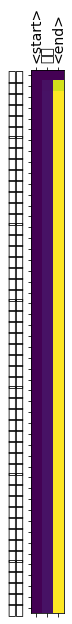

In [153]:
data